In [6]:
import os
import cv2
import shutil
from PIL import Image
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
device = torch.device('mps')
print('all the import are successfull')

#importing CV realted libraries 
from torch import nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

all the import are successfull
PyTorch version: 2.3.0
torchvision version: 0.18.0


### Organizing the Data for train and test

In [30]:
root_dir = '/Users/mukulkumar/Desktop/ML-and-DL/project2/'
train_dir = root_dir + 'train'
test_dir = root_dir + 'test'

os.makedirs(train_dir, exist_ok= True)
os.makedirs(test_dir, exist_ok= True)

dataset_path = '/Users/mukulkumar/Desktop/ML-and-DL/Datasets/data/'
classes = os.listdir('/Users/mukulkumar/Desktop/ML-and-DL/Datasets/data/')
classes = [clas for clas in classes if clas != '.DS_Store']

if os.path.exists(train_dir):
    for each_class in classes:
        #check if the class directory is already being present or not.
        #if present then skip if not then create the directory and store the file in it
        if not os.path.exists(train_dir + '/' + each_class):
            os.mkdir(train_dir + '/' + each_class)
            print(f'directory created for: {each_class}')
            #after creating the 
        else:
            print('already exist')

if os.path.exists(test_dir):
    for each_class in classes:
        #check if the class directory is already being present or not.
        #if present then skip if not then create the directory and store the file in it
        if not os.path.exists(test_dir + '/' + each_class):
            os.mkdir(test_dir + '/' + each_class)
            print(f'directory created for: {each_class}')
            #after creating the 
        else:
            print('already exist')


#injecting data class subfolder of train and test dir
split = 0.7
for each in classes:
    each_class_files = os.listdir('/Users/mukulkumar/Desktop/ML-and-DL/Datasets/data/' + each + '/')
    split = int(len(each_class_files) * 0.7)
    train_data = each_class_files[:split]
    test_data = each_class_files[split:]
    print(f'{each} | train_length: {len(train_data)} | test_legth : {len(test_data)}')

    #copyinf each file to respected class folder
    for train_sample in train_data:
        shutil.copy(src= dataset_path + each + '/' + train_sample,dst= train_dir + '/' + each + '/' + train_sample)

    for test_sample in test_data:
        shutil.copy(src= dataset_path + each + '/' + test_sample,dst= test_dir + '/' + each + '/' + test_sample)




directory created for: cloudy
directory created for: water
directory created for: green_area
directory created for: desert
directory created for: cloudy
directory created for: water
directory created for: green_area
directory created for: desert
cloudy | train_length: 1050 | test_legth : 450
water | train_length: 1050 | test_legth : 450
green_area | train_length: 1050 | test_legth : 450
desert | train_length: 791 | test_legth : 340


#### DataLoaders and Visualizing the dataset

In [2]:
#define the transformation on to the datasets
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()])

#creating the datasets
train_dataset = datasets.ImageFolder(root='../Datasets/dataset1/seg_train/seg_train',transform=transform)
test_dataset = datasets.ImageFolder(root= '../Datasets/dataset1/seg_test/seg_test',transform=transform)

#creating the data loaders for the training and the testing part
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle= True)
test_loader = DataLoader(dataset=test_dataset,batch_size=64,shuffle=True)


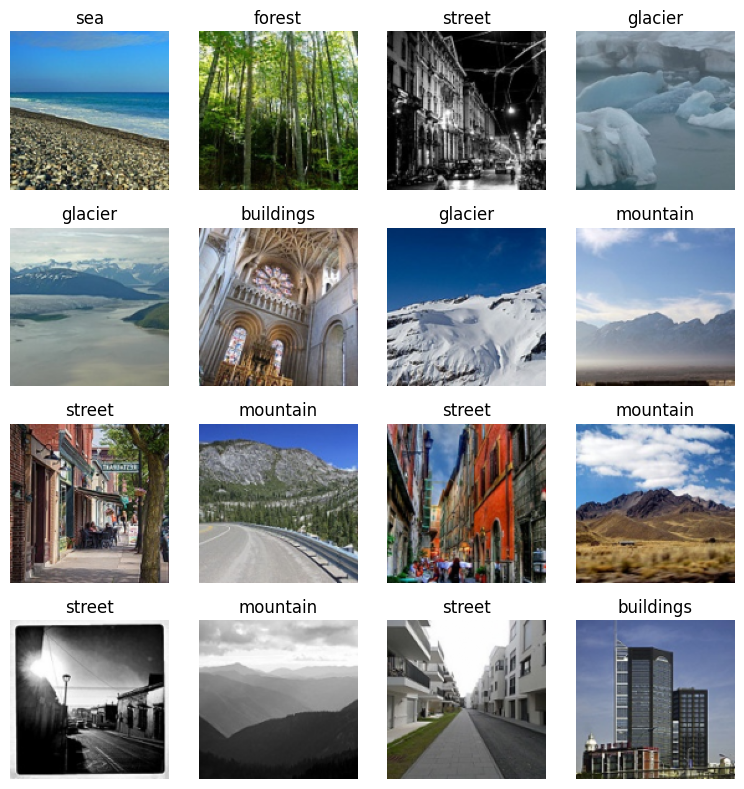

In [3]:
# showing the image of training Data

class_name = train_dataset.classes

torch.manual_seed(41)
n_rows = 4
n_cols = 4

fig = plt.figure(figsize=(8,8))
for i in range(1, n_rows*n_cols + 1):
    idx = torch.randint(0,len(train_dataset), size=[1]).item()
    image, label = train_dataset[idx]

    #to show an image the format has to be (H,W,C) not (C,H,W)
    img_array = image.permute(1,2,0).numpy()
    plt.subplot(n_rows,n_cols,i)
    plt.imshow(img_array)
    plt.axis('off')
    plt.title(class_name[label])
    plt.axis(False)
    plt.tight_layout()

### Classification using Dense

In [4]:
class model_0(nn.Module):
    def __init__(self):
        super().__init__()
        #flatten the input image as NN input is in vectopr form
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(in_features=49152, out_features=1024)
        self.layer2 = nn.Linear(in_features=1024, out_features=512)
        self.layer3 = nn.Linear(in_features=512, out_features=512)
        self.layer4 = nn.Linear(in_features=512, out_features=128)
        self.layer5 = nn.Linear(in_features=128, out_features=6)
        self.relu = nn.ReLU()
    
    #defining the forward pass
    def forward(self,x):
        flattened_output = self.flatten(x)
        out1 = self.relu(self.layer1(flattened_output))
        out2 = self.relu(self.layer2(out1))
        out3 = self.relu(self.layer3(out2))
        out4 = self.relu(self.layer4(out3))
        output_logits = self.layer5(out4)   #output layer
        return output_logits

#initiate the model

model0 = model_0().to(device=device)
model0



model_0(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=49152, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=128, bias=True)
  (layer5): Linear(in_features=128, out_features=6, bias=True)
  (relu): ReLU()
)

In [5]:
#set up the loss function and the optimizer and accuracy
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr = 0.005)

def accuracy_fun(y_pred,y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct/len(y_true))*100
    return acc

In [6]:
#define the training and testing

torch.manual_seed(42)

epochs = 5
epoch_count = []
training_loss = []
training_acc = []

for epoch in range(epochs):
    print(f"Epoch No: {epoch}\n-------")

    #training the model
    train_loss = 0
    train_accuracy = 0

    for batch, (X,y) in enumerate(train_loader):

        #send to device
        X = X.to(device)
        y = y.to(device)
        model0.train()

        #forward pass
        y_logits = model0(X)
        y_pred = torch.softmax(y_logits,dim=1)
        y_pred = torch.argmax(y_pred,dim=1)

        #calculate the loss for the batch
        loss = loss_fun(y_logits, y)
        #sum all the training loss of the batches in one epoch
        train_loss = train_loss + loss

        #calulate accuracy for each batch
        train_acc = accuracy_fun(y_true=y, y_pred=y_pred)
        train_accuracy = train_accuracy + train_acc

        #optimizer zero grad
        optimizer.zero_grad()

        #loss backward
        loss.backward()

        #update the weight
        optimizer.step()

    #print('the reuslt after each epoch)
    train_loss = train_loss/len(train_loader)
    train_accuracy = train_accuracy/len(train_loader)
    epoch_count.append(epoch)
    training_loss.append(train_loss.cpu().item())
    training_acc.append(train_accuracy)
    print(f'batch : {batch} | train_loss = {train_loss} | train_accurracy: {train_accuracy}')
        



Epoch No: 0
-------
batch : 219 | train_loss = 2.337423086166382 | train_accurracy: 36.05508207070707
Epoch No: 1
-------
batch : 219 | train_loss = 1.344853162765503 | train_accurracy: 47.636521464646464
Epoch No: 2
-------
batch : 219 | train_loss = 1.2944443225860596 | train_accurracy: 49.99131944444444
Epoch No: 3
-------
batch : 219 | train_loss = 1.2583396434783936 | train_accurracy: 51.04719065656566
Epoch No: 4
-------
batch : 219 | train_loss = 1.227705955505371 | train_accurracy: 52.503945707070706


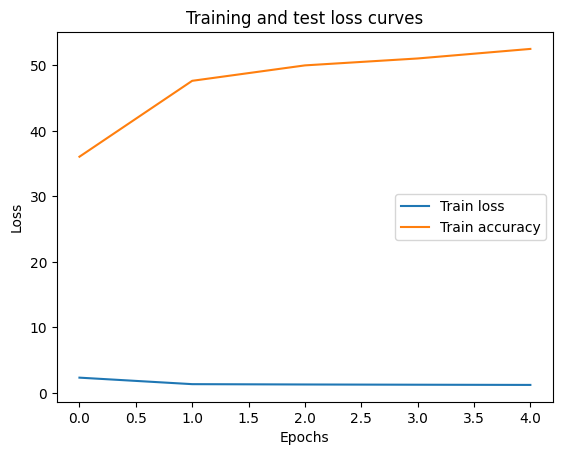

In [16]:
plt.plot(epoch_count, training_loss, label="Train loss")
plt.plot(epoch_count, training_acc, label="Train accuracy")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()